# Titanic Machine Learning Project

The goal of this project is to build a machine learning model that predicts which passengers survived the Titanic with the greatest possible accuracy.

## 1. Imports and Data Cleaning

In this section, I import the data and clean it to prepare it for modeling.

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, log_loss
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
train_df = pd.read_csv('Data/train.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df = pd.read_csv('Data/test.csv')

In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Only 38% of passengers survived.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train_df.drop('Cabin',inplace=True,axis=1)

In [9]:
test_df.drop('Cabin',inplace=True,axis=1)

### 1a. Cleaning Age Null Values

One thing that stands out when looking at the null values in the age column is that all of the names have titles, some of which seem to point to the age of the passenger.

In [10]:
train_df[train_df['Age'].isna()].head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,C
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,Q
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,C
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,C


Most of the females have either a Miss or Mrs title and males have either a Mr or Master title. These offer general indications of passenger age, so I use them to approximate the ages of the passengers that have null values for age. I create a feature for title and use it to approximate the missing ages.

In [11]:
train_df['Title'] = train_df['Name'].str.extract(r',\s*([^,]+)\.')

In [12]:
train_df['Title'].value_counts()

Mr                          517
Miss                        182
Mrs                         124
Master                       40
Dr                            7
Rev                           6
Mlle                          2
Col                           2
Major                         2
Sir                           1
Mrs. Martin (Elizabeth L      1
Don                           1
Mme                           1
Lady                          1
Jonkheer                      1
Ms                            1
the Countess                  1
Capt                          1
Name: Title, dtype: int64

In [13]:
train_df.loc[train_df['Title'] == 'Mrs. Martin (Elizabeth L','Title'] = 'Mrs'
train_df.loc[train_df['Title'] == 'Mme','Title'] = 'Mrs'
train_df.loc[train_df['Title'] == 'Ms','Title'] = 'Miss'
train_df.loc[train_df['Title'] == 'Mlle','Title'] = 'Miss'
train_df.loc[train_df['Title'].str.contains('Countess|Lady', case=False), 'Title'] = 'Mrs'
train_df.loc[train_df['Title'].str.contains('Dr|Rev|Col|Major|Sir|Capt|Don|Jonkheer', case=False), 'Title'] = 'Special_Title_Male'

In [14]:
train_df['Title'].value_counts()

Mr                    517
Miss                  185
Mrs                   128
Master                 40
Special_Title_Male     21
Name: Title, dtype: int64

In [15]:
train_df.groupby(by='Title').median()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Title,,,,,,,
Master,345.0,1.0,3.0,3.5,1.0,1.0,29.0625
Miss,388.0,1.0,3.0,21.0,0.0,0.0,15.7417
Mr,466.0,0.0,3.0,30.0,0.0,0.0,9.3500
Mrs,439.5,1.0,2.0,35.0,1.0,0.0,26.0000
Special_Title_Male,627.0,0.0,1.0,49.0,0.0,0.0,26.5500


In [16]:
train_df.loc[train_df['Title'] == 'Master', 'Age'] = train_df.loc[train_df['Title'] == 'Master', 'Age'].fillna(3.5)
train_df.loc[train_df['Title'] == 'Miss', 'Age'] = train_df.loc[train_df['Title'] == 'Miss', 'Age'].fillna(21)
train_df.loc[train_df['Title'] == 'Mr', 'Age'] = train_df.loc[train_df['Title'] == 'Mr', 'Age'].fillna(31)
train_df.loc[train_df['Title'] == 'Mrs', 'Age'] = train_df.loc[train_df['Title'] == 'Mrs', 'Age'].fillna(35)
train_df.loc[train_df['Title'] == 'Special_Title_Male', 'Age'] = train_df.loc[train_df['Title'] == 'Special_Title_Male', 'Age'].fillna(49)

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
 11  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


I use the same process for the test data set.

In [18]:
test_df['Title'] = test_df['Name'].str.extract(r',\s*([^,]+)\.')

In [19]:
test_df['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Dr          1
Ms          1
Name: Title, dtype: int64

In [20]:
test_df.loc[test_df['Title'] == 'Ms','Title'] = 'Miss'
test_df.loc[test_df['Title'] =='Dona', 'Title'] = 'Mrs'
test_df.loc[test_df['Title'].str.contains('Dr|Rev|Col', case=False), 'Title'] = 'Special_Title_Male'

In [21]:
test_df['Title'].value_counts()

Mr                    240
Miss                   79
Mrs                    73
Master                 21
Special_Title_Male      5
Name: Title, dtype: int64

In [22]:
test_df.loc[test_df['Title'] == 'Master', 'Age'] = test_df.loc[test_df['Title'] == 'Master', 'Age'].fillna(3.5)
test_df.loc[test_df['Title'] == 'Miss', 'Age'] = test_df.loc[test_df['Title'] == 'Miss', 'Age'].fillna(21)
test_df.loc[test_df['Title'] == 'Mr', 'Age'] = test_df.loc[test_df['Title'] == 'Mr', 'Age'].fillna(31)
test_df.loc[test_df['Title'] == 'Mrs', 'Age'] = test_df.loc[test_df['Title'] == 'Mrs', 'Age'].fillna(35)
test_df.loc[test_df['Title'] == 'Special_Title_Female', 'Age'] = test_df.loc[test_df['Title'] == 'Special_Title_Female', 'Age'].fillna(40.5)
test_df.loc[test_df['Title'] == 'Special_Title_Male', 'Age'] = test_df.loc[test_df['Title'] == 'Special_Title_Male', 'Age'].fillna(49)

In [23]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Embarked     418 non-null    object 
 10  Title        418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The final null values come from the embarked column for the train data and the fare column for the test data.

### 1c. Cleaning null values in the Embarked and Fare columns

The Embarked column shows the port of embarkment for each passenger. I add these passengers to the most common port.

In [24]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [25]:
train_df[train_df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,Mrs


In [26]:
train_df['Embarked'].fillna('S',inplace=True)

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [28]:
test_df[test_df['Fare'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,Mr


In [29]:
train_df[train_df['Pclass'] == 3].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,491.000000,491.000000,491.0,491.000000,491.000000,491.000000,491.000000
mean,439.154786,0.242363,3.0,25.940774,0.615071,0.393075,13.675550
std,264.441453,0.428949,0.0,11.190488,1.374883,0.888861,11.778142
min,1.000000,0.000000,3.0,0.420000,0.000000,0.000000,0.000000
25%,200.000000,0.000000,3.0,20.000000,0.000000,0.000000,7.750000
50%,432.000000,0.000000,3.0,27.000000,0.000000,0.000000,8.050000
75%,666.500000,0.000000,3.0,31.000000,1.000000,0.000000,15.500000
max,891.000000,1.000000,3.0,74.000000,8.000000,6.000000,69.550000


In [30]:
test_df['Fare'].fillna(8.05,inplace=True)

In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Embarked     418 non-null    object 
 10  Title        418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Hooray! There are no more null values. The next step is preparing for modeling.

## 2. EDA

### 2a. Class

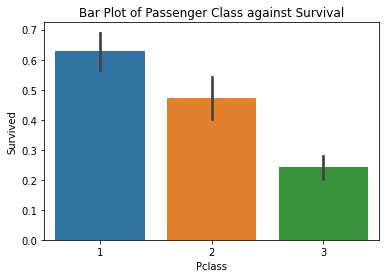

In [32]:
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.xlabel('Pclass')
plt.ylabel('Survived')
plt.title('Bar Plot of Passenger Class against Survival');

In [33]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

There were more than double the amount of passengers in class 3 as there were in class 1, but the passengers in class 3 had roughly 1/3 the survival rate as the passengers in class 1.

### 2b. Sex

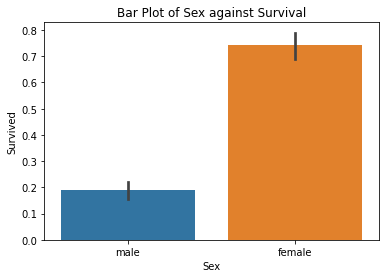

In [34]:
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.xlabel('Sex')
plt.ylabel('Survived')
plt.title('Bar Plot of Sex against Survival');

In [35]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Males outnumbered females, and the survival rate for males was approximately 1/4 that of females.

### 2c. Age

To visualize passenger age, I bin the ages into ranges.

In [36]:
train_df['Age_Bins'] = pd.cut(train_df['Age'],bins=12)

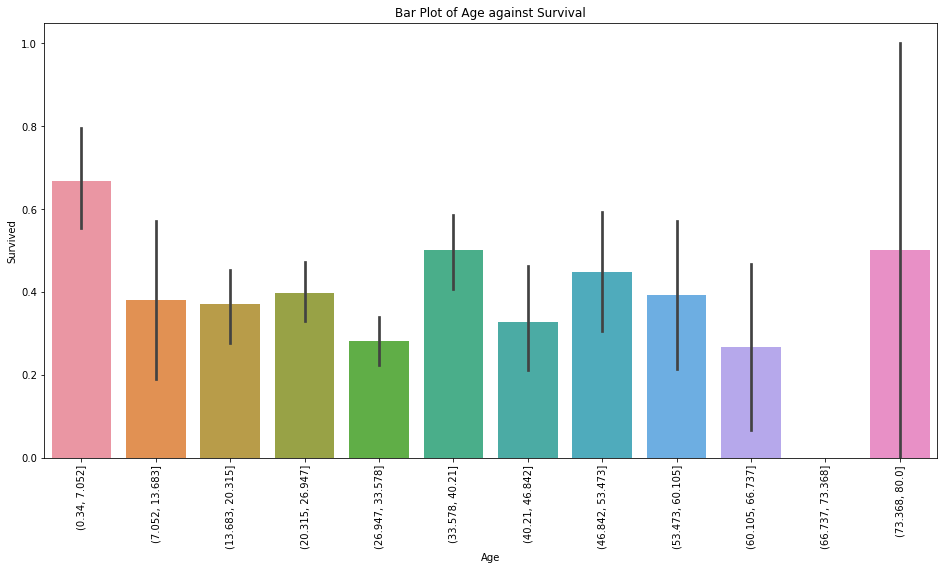

In [37]:
plt.figure(figsize=(16,8))
sns.barplot(x='Age_Bins', y='Survived', data=train_df)

plt.xlabel('Age')
plt.xticks(rotation='vertical')
plt.ylabel('Survived')
plt.title('Bar Plot of Age against Survival');

Children under the age of 7 had the strongest survival rates of any age group.

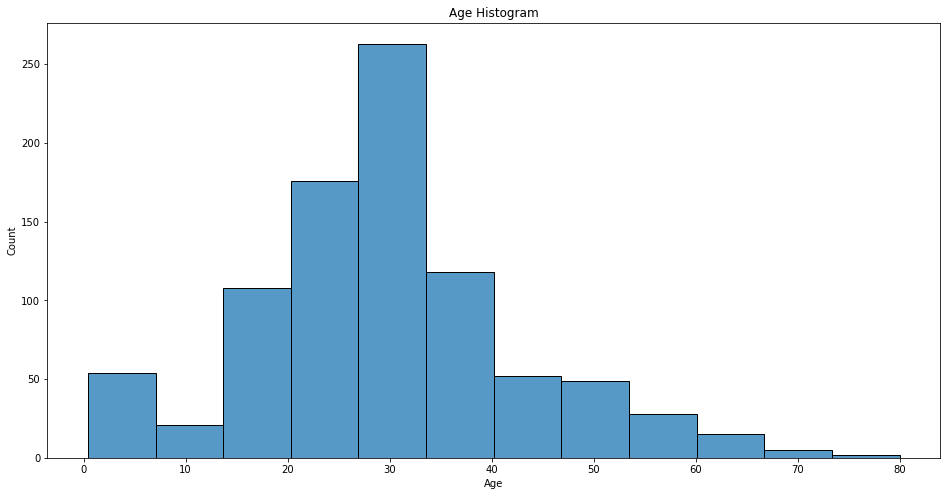

In [38]:
plt.figure(figsize=(16,8))
sns.histplot(x='Age',bins=12,data=train_df)
plt.title('Age Histogram');

Children below the age of 7 represented a small part of the data. I investigate further to see how age and sex relate.

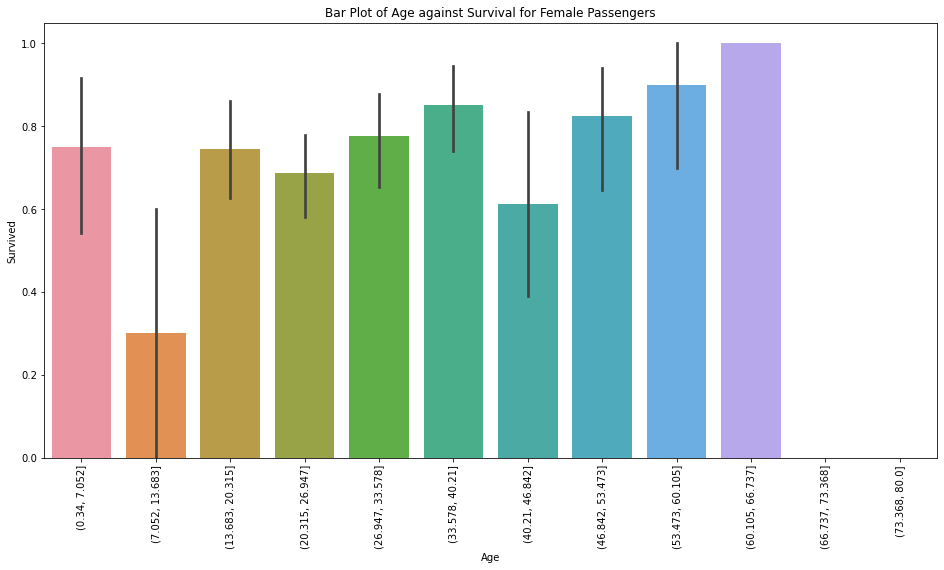

In [39]:
plt.figure(figsize=(16,8))
sns.barplot(x='Age_Bins', y='Survived', data=train_df[train_df['Sex']=='female'])

plt.xlabel('Age')
plt.xticks(rotation='vertical')
plt.ylabel('Survived')
plt.title('Bar Plot of Age against Survival for Female Passengers');

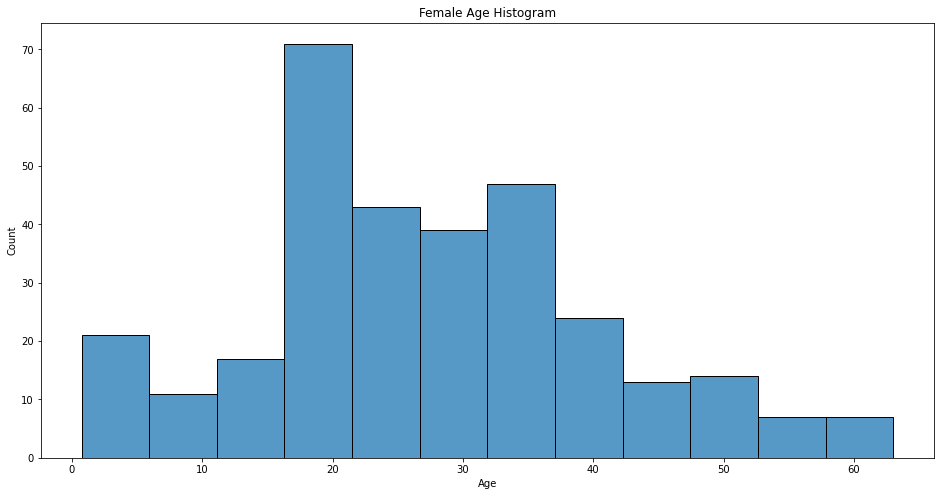

In [40]:
plt.figure(figsize=(16,8))
sns.histplot(x='Age',bins=12,data=train_df[train_df['Sex']=='female'])
plt.title('Female Age Histogram');

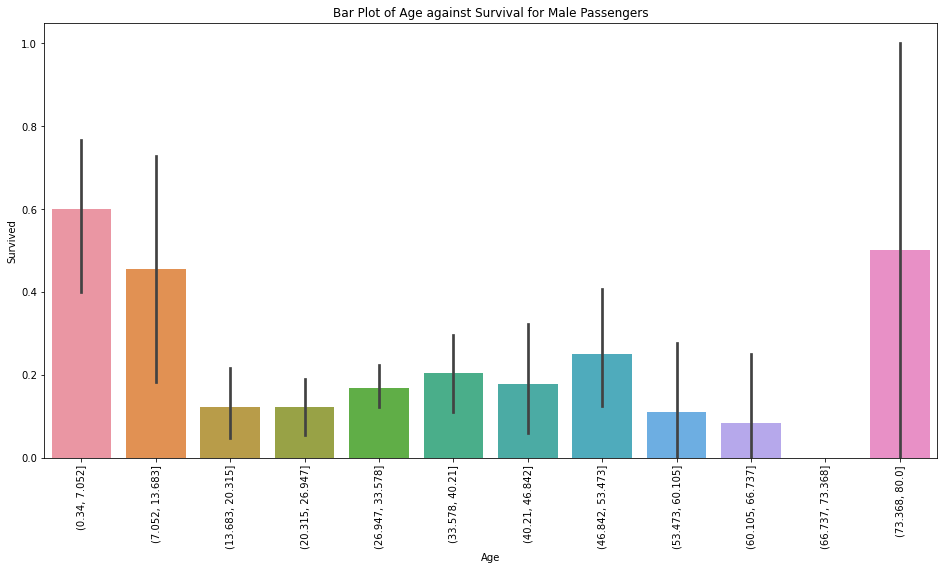

In [41]:
plt.figure(figsize=(16,8))
sns.barplot(x='Age_Bins', y='Survived', data=train_df[train_df['Sex']=='male'])

plt.xlabel('Age')
plt.xticks(rotation='vertical')
plt.ylabel('Survived')
plt.title('Bar Plot of Age against Survival for Male Passengers');

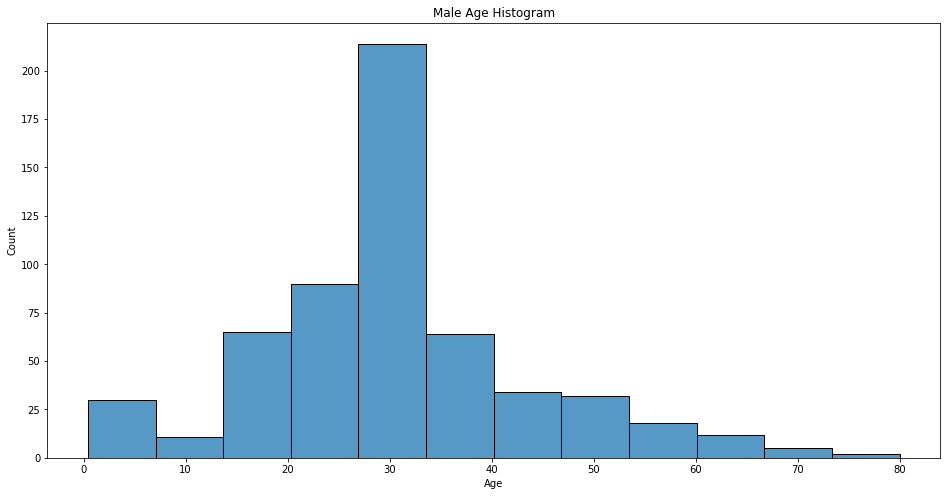

In [42]:
plt.figure(figsize=(16,8))
sns.histplot(x='Age',bins=12,data=train_df[train_df['Sex']=='male'])
plt.title('Male Age Histogram');

Age does not play a significant role for remale passengers. While there are some fluctuations in survival rate across age groups, it is likely due to sample size. Generally, across all age groups, the survival rate for females is above 70%. For males, age plays a substantial role. Children below the age of 13 had substantially higher survival rates than children above 13. Based on this information, I create a new feature.

### 2d. Family

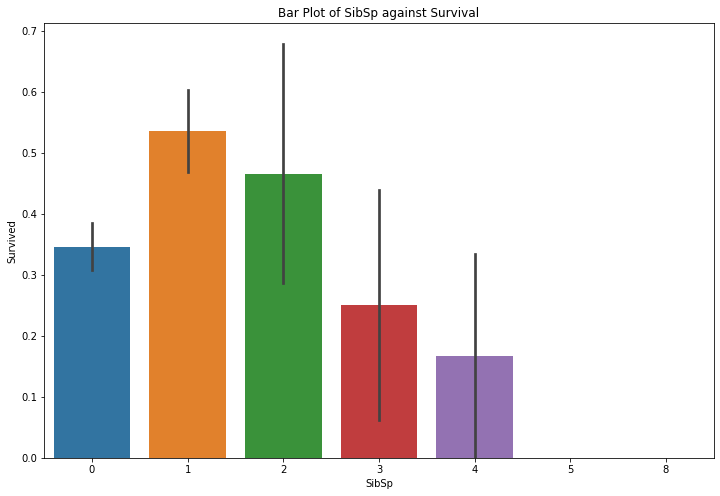

In [43]:
plt.figure(figsize=(12,8))
sns.barplot(x='SibSp', y='Survived', data=train_df)
plt.xlabel('SibSp')
plt.ylabel('Survived')
plt.title('Bar Plot of SibSp against Survival');

In [44]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [45]:
train_df[train_df['SibSp'] > 2].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,371.086957,0.152174,2.847826,12.413043,4.369565,1.565217,52.115039
std,288.262598,0.363158,0.514993,9.608621,1.678077,0.583178,58.564411
min,8.000000,0.000000,1.000000,1.000000,3.000000,0.000000,7.925000
25%,130.000000,0.000000,3.000000,4.000000,3.000000,1.000000,27.900000
50%,273.000000,0.000000,3.000000,9.000000,4.000000,2.000000,31.331250
75%,641.000000,0.000000,3.000000,21.000000,4.750000,2.000000,46.900000
max,864.000000,1.000000,3.000000,33.000000,8.000000,2.000000,263.000000


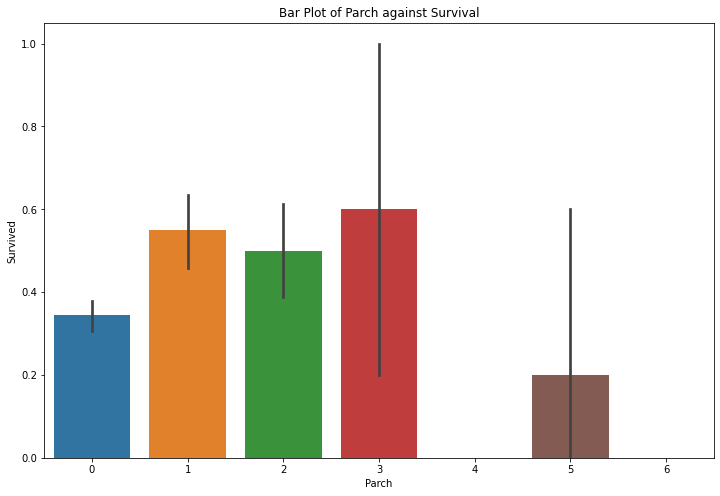

In [46]:
plt.figure(figsize=(12,8))
sns.barplot(x='Parch', y='Survived', data=train_df)
plt.xlabel('Parch')
plt.ylabel('Survived')
plt.title('Bar Plot of Parch against Survival');

In [47]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [48]:
train_df[train_df['Parch']>2]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Age_Bins
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,S,Mr,"(33.578, 40.21]"
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,S,Mrs,"(33.578, 40.21]"
86,87,0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.3750,S,Mr,"(13.683, 20.315]"
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,S,Mrs,"(40.21, 46.842]"
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9000,S,Mr,"(33.578, 40.21]"
437,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,S,Mrs,"(20.315, 26.947]"
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,S,Mr,"(60.105, 66.737]"
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,S,Mrs,"(26.947, 33.578]"
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,S,Mrs,"(33.578, 40.21]"
638,639,0,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,S,Mrs,"(40.21, 46.842]"


In [49]:
train_df['Family'] = train_df['SibSp'] + train_df['Parch']

In [50]:
train_df['Family'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

In [51]:
train_df.loc[train_df['Family'] == 0,'Family_Grouped'] = 'None'
train_df.loc[(train_df['Family'] >= 1) & (train_df['Family'] <= 3),'Family_Grouped'] = 'Small'
train_df.loc[train_df['Family'] > 3,'Family_Grouped'] = 'Large'

In [52]:
train_df['Family_Grouped'].value_counts()

None     537
Small    292
Large     62
Name: Family_Grouped, dtype: int64

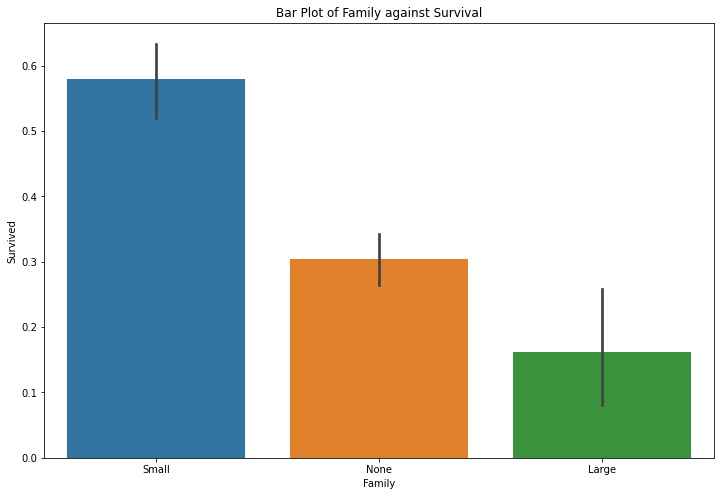

In [53]:
plt.figure(figsize=(12,8))
sns.barplot(x='Family_Grouped', y='Survived', data=train_df)
plt.xlabel('Family')
plt.ylabel('Survived')
plt.title('Bar Plot of Family against Survival');

### 2e. Embarkment

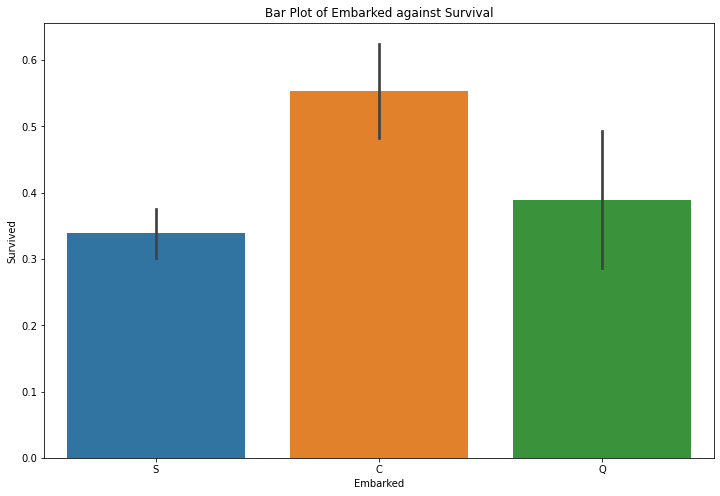

In [54]:
plt.figure(figsize=(12,8))
sns.barplot(x='Embarked', y='Survived', data=train_df)
plt.xlabel('Embarked')
plt.ylabel('Survived')
plt.title('Bar Plot of Embarked against Survival');

### 2f. Title

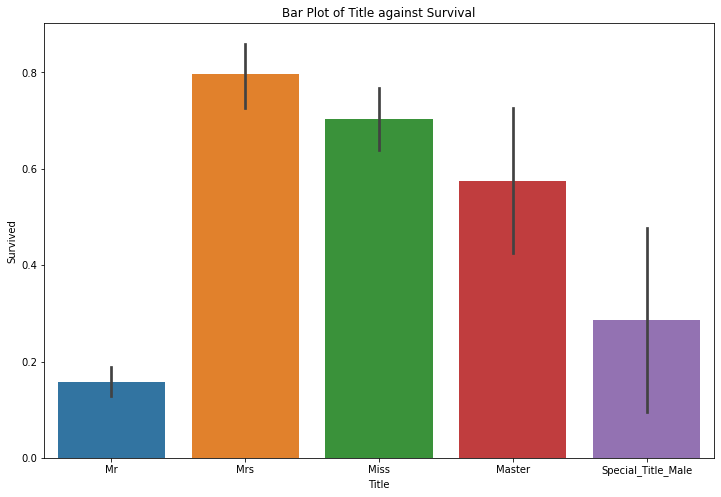

In [55]:
plt.figure(figsize=(12,8))
sns.barplot(x='Title', y='Survived', data=train_df)
plt.xlabel('Title')
plt.ylabel('Survived')
plt.title('Bar Plot of Title against Survival');

### 2g. Fare

In [56]:
train_df['Fare_Bins'] = pd.cut(train_df['Fare'],bins=100)

In [57]:
train_df['Fare_Bins'].value_counts()

(5.123, 10.247]       320
(10.247, 15.37]       129
(25.616, 30.74]       104
(15.37, 20.493]        53
(20.493, 25.616]       43
                     ... 
(502.083, 507.206]      0
(256.165, 261.288]      0
(374.0, 379.124]        0
(266.411, 271.534]      0
(251.041, 256.165]      0
Name: Fare_Bins, Length: 100, dtype: int64

In [58]:
train_df.groupby(by='Fare_Bins').mean().head(20)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family
Fare_Bins,,,,,,,,
"(-0.512, 5.123]",529.294118,0.058824,1.941176,32.176471,0.000000,0.000000,0.530147,0.000000
"(5.123, 10.247]",447.759375,0.206250,3.000000,28.215375,0.084375,0.031250,7.894308,0.115625
"(10.247, 15.37]",445.984496,0.387597,2.294574,29.280388,0.186047,0.224806,12.722512,0.410853
"(15.37, 20.493]",400.358491,0.509434,2.867925,24.355283,0.886792,0.547170,17.245283,1.433962
"(20.493, 25.616]",432.906977,0.372093,2.674419,24.593023,1.186047,0.883721,22.744770,2.069767
"(25.616, 30.74]",447.115385,0.490385,1.653846,33.243558,0.605769,0.548077,27.365783,1.153846
"(30.74, 35.863]",398.290323,0.354839,2.096774,28.387097,1.354839,1.419355,32.837768,2.774194
"(35.863, 40.986]",545.263158,0.368421,2.052632,23.210526,1.578947,1.052632,38.887284,2.631579
"(40.986, 46.11]",485.500000,0.500000,1.750000,20.250000,0.750000,1.500000,41.784400,2.250000


In [59]:
train_df[train_df['Fare']<5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Age_Bins,Family,Family_Grouped,Fare_Bins
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,S,Mr,"(33.578, 40.21]",0,None,"(-0.512, 5.123]"
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,S,Mr,"(33.578, 40.21]",0,None,"(-0.512, 5.123]"
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,S,Mr,"(20.315, 26.947]",0,None,"(-0.512, 5.123]"
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,31.0,0,0,239853,0.0000,S,Mr,"(26.947, 33.578]",0,None,"(-0.512, 5.123]"
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,S,Mr,"(13.683, 20.315]",0,None,"(-0.512, 5.123]"
378,379,0,3,"Betros, Mr. Tannous",male,20.0,0,0,2648,4.0125,C,Mr,"(13.683, 20.315]",0,None,"(-0.512, 5.123]"
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,31.0,0,0,239853,0.0000,S,Mr,"(26.947, 33.578]",0,None,"(-0.512, 5.123]"
466,467,0,2,"Campbell, Mr. William",male,31.0,0,0,239853,0.0000,S,Mr,"(26.947, 33.578]",0,None,"(-0.512, 5.123]"
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,31.0,0,0,239854,0.0000,S,Mr,"(26.947, 33.578]",0,None,"(-0.512, 5.123]"
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,S,Mr,"(46.842, 53.473]",0,None,"(-0.512, 5.123]"


In [60]:
train_df[(train_df['Fare']>=5)&(train_df['Fare']<10)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Age_Bins,Family,Family_Grouped,Fare_Bins
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,"(20.315, 26.947]",1,Small,"(5.123, 10.247]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,"(20.315, 26.947]",0,None,"(5.123, 10.247]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,"(33.578, 40.21]",0,None,"(5.123, 10.247]"
5,6,0,3,"Moran, Mr. James",male,31.0,0,0,330877,8.4583,Q,Mr,"(26.947, 33.578]",0,None,"(5.123, 10.247]"
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,S,Mr,"(13.683, 20.315]",0,None,"(5.123, 10.247]"


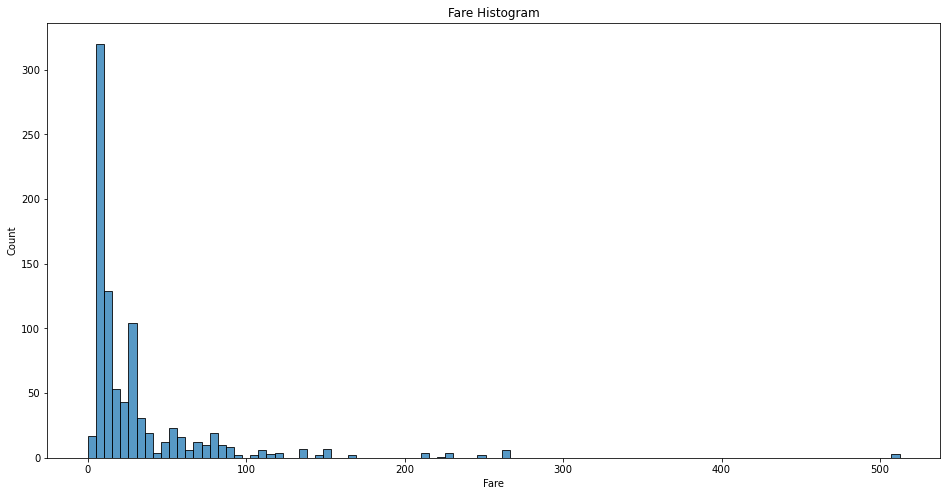

In [61]:
plt.figure(figsize=(16,8))
sns.histplot(x='Fare',bins=100,data=train_df)
plt.title('Fare Histogram');

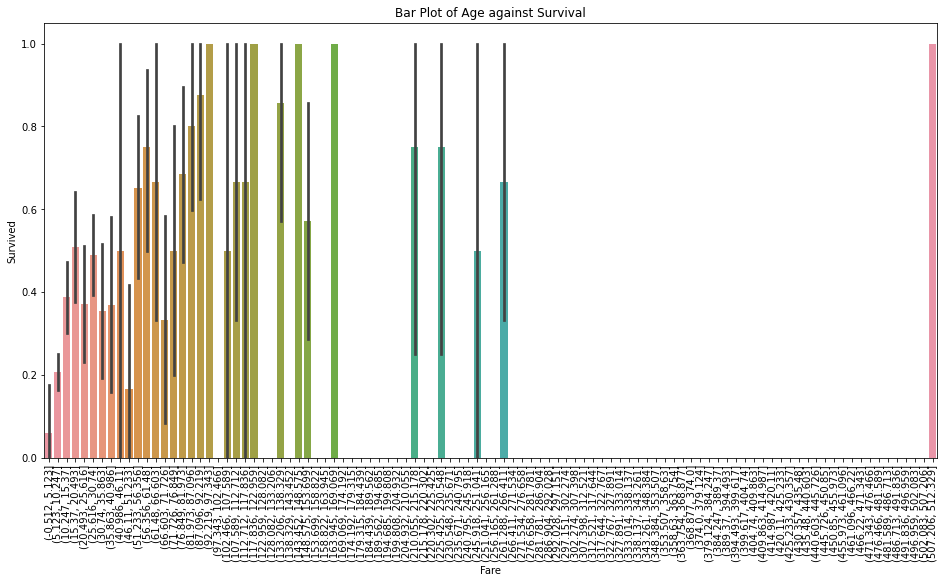

In [62]:
plt.figure(figsize=(16,8))
sns.barplot(x='Fare_Bins', y='Survived', data=train_df)

plt.xlabel('Fare')
plt.xticks(rotation='vertical')
plt.ylabel('Survived')
plt.title('Bar Plot of Age against Survival');

In [63]:
train_df[train_df['Fare'] > 75].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family
count,97.000000,97.000000,97.0,97.000000,97.000000,97.000000,97.000000,97.000000
mean,451.773196,0.762887,1.0,34.638351,0.628866,0.608247,139.612327,1.237113
std,230.747405,0.427522,0.0,14.228697,0.711799,0.860677,88.259168,1.256427
min,28.000000,0.000000,1.0,0.920000,0.000000,0.000000,75.250000,0.000000
25%,291.000000,1.000000,1.0,24.000000,0.000000,0.000000,82.170800,0.000000
50%,436.000000,1.000000,1.0,35.000000,1.000000,0.000000,110.883300,1.000000
75%,660.000000,1.000000,1.0,45.000000,1.000000,1.000000,153.462500,2.000000
max,880.000000,1.000000,1.0,64.000000,3.000000,4.000000,512.329200,5.000000


In [64]:
train_df[(train_df['Fare'] > 10) & (train_df['Fare'] < 75)].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000
mean,440.984716,0.438865,2.117904,29.238712,0.825328,0.591703,27.568850,1.417031
std,260.667091,0.496791,0.773796,15.181431,1.389257,0.966222,15.881122,1.954262
min,2.000000,0.000000,1.000000,0.670000,0.000000,0.000000,10.170800,0.000000
25%,203.000000,0.000000,2.000000,21.000000,0.000000,0.000000,14.500000,0.000000
50%,447.500000,0.000000,2.000000,30.000000,0.000000,0.000000,25.964600,1.000000
75%,665.250000,1.000000,3.000000,36.375000,1.000000,1.000000,31.387500,2.000000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,73.500000,10.000000


In [65]:
train_df[train_df['Fare'] < 10].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,451.169643,0.199405,2.946429,28.443214,0.080357,0.029762,7.514941,0.110119
std,260.644822,0.400149,0.294404,9.339597,0.357564,0.202244,1.758240,0.479196
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,222.500000,0.000000,3.000000,21.000000,0.000000,0.000000,7.449975,0.000000
50%,455.500000,0.000000,3.000000,29.000000,0.000000,0.000000,7.854200,0.000000
75%,676.250000,0.000000,3.000000,31.000000,0.000000,0.000000,8.050000,0.000000
max,891.000000,1.000000,3.000000,74.000000,4.000000,2.000000,9.845800,6.000000


In [66]:
train_df.loc[train_df['Fare'] >= 75,'Fare_Level'] = 'High'
train_df.loc[(train_df['Fare'] > 10) & (train_df['Fare'] < 75), 'Fare_Level'] = 'Medium'
train_df.loc[(train_df['Fare'] > 0) & (train_df['Fare'] <= 10),'Fare_Level'] = 'Low'
train_df.loc[train_df['Fare'] == 0,'Fare_Level'] = 'Free'

In [67]:
test_df.loc[test_df['Fare'] >= 75,'Fare_Level'] = 'High'
test_df.loc[(test_df['Fare'] > 10) & (test_df['Fare'] < 75), 'Fare_Level'] = 'Medium'
test_df.loc[(test_df['Fare'] > 0) & (test_df['Fare'] <= 10),'Fare_Level'] = 'Low'
test_df.loc[test_df['Fare'] == 0,'Fare_Level'] = 'Free'

## 3. Preparing for Modeling

Now I define the X and Y .

In [68]:
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']
X_test = test_df

Next, I define which columns need one hot encoding and which are already numerical.

In [69]:
ohecols = ['Embarked','Title','Fare_Level','Family_Grouped']

In [70]:
numcols = ['Pclass']

In [71]:
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [72]:
ohe_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', onehot)
])

In [73]:
num_sub = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent'))
])

In [74]:
CT = ColumnTransformer(transformers=[
    ('onehot', ohe_sub, ohecols),
    ('numerical', num_sub, numcols)
])

In [75]:
dum_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [76]:
dum_pipe.fit(X_train, y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked', 'Title',
                                                   'Fare_Level',
                                                   'Family_Grouped']),
                                                 ('numerical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Pclass'])])),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

In [77]:
print(classification_report(y_train, dum_pipe.predict(X_train)))

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.62      1.00      0.76       549
           1       0.00      0.00      0.00       342

    accuracy                           0.62       891
   macro avg       0.31      0.50      0.38       891
weighted avg       0.38      0.62      0.47       891



C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4. Modeling

### 4a. Logistic Regression

In [78]:
lr_pipe = Pipeline(steps=[
    ('ct', CT),
    ('lr', LogisticRegression(max_iter=1000))
])

In [79]:
lr_pipe.fit(X_train, y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked', 'Title',
                                                   'Fare_Level',
                                                   'Family_Grouped']),
                                                 ('numerical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Pclass'])])),
                ('lr', LogisticRegression(max_iter=1000))])

In [80]:
print(classification_report(y_train, lr_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       549
           1       0.81      0.74      0.77       342

    accuracy                           0.83       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.83      0.83       891



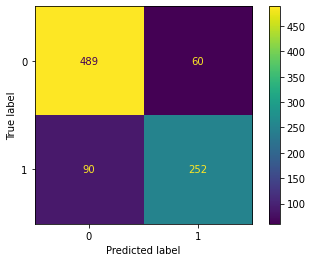

In [81]:
ConfusionMatrixDisplay.from_estimator(lr_pipe, X_train, y_train);

In [82]:
params = {
    'fsm__max_iter' : [10, 100, 1000, 10000],
    'fsm__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'fsm__tol' : [0.0001,0.001,0.01,0.1],
    'fsm__penalty' : ['l2','none'],
    'fsm__class_weight' : [None,'balanced']
}

In [83]:
gs = GridSearchCV(
    estimator = lr_pipe,
    param_grid = params,
    cv = 5,
    verbose = 1
)

In [84]:
#gs.fit(X,y)

In [85]:
#gs.best_params_

In [86]:
lr_gs_pipe = Pipeline(steps=[
    ('ct', CT),
    ('lr', LogisticRegression(C = .1,
                               class_weight = None,
                               max_iter=100,
                               penalty = 'l2',
                               tol = .0001))
])

In [87]:
lr_gs_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked', 'Title',
                                                   'Fare_Level',
                                                   'Family_Grouped']),
                                                 ('numerical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Pclass'])])),
                ('lr', LogisticRegression(C=0.1))])

In [88]:
print(classification_report(y_train, lr_gs_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       549
           1       0.79      0.76      0.77       342

    accuracy                           0.83       891
   macro avg       0.82      0.82      0.82       891
weighted avg       0.83      0.83      0.83       891



In [89]:
lr_coefs = lr_gs_pipe.named_steps['lr'].coef_

In [90]:
lr_coefs

array([[ 0.15496544,  0.05558813, -0.21055161,  0.44663811,  0.78880738,
        -1.51992169,  0.82688886, -0.54241069, -0.20020596,  0.19419833,
        -0.0059516 ,  0.0119612 , -0.73203806,  0.26761914,  0.46442088,
        -0.72786815]])

In [91]:
X_transformed = CT.fit_transform(X_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [92]:
X_transformed

array([[0., 0., 1., ..., 0., 1., 3.],
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 3.],
       ...,
       [0., 0., 1., ..., 0., 1., 3.],
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 3.]])

In [93]:
feature_names = CT.named_transformers_['onehot'].get_feature_names_out(input_features=ohecols)

In [94]:
postohecols = feature_names.tolist()

In [95]:
allcols = postohecols + numcols

In [96]:
lr_feature_importance_df = pd.DataFrame(lr_coefs, columns = allcols)

In [97]:
lr_feature_importance_df

,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Special_Title_Male,Fare_Level_Free,Fare_Level_High,Fare_Level_Low,Fare_Level_Medium,Family_Grouped_Large,Family_Grouped_None,Family_Grouped_Small,Pclass
0,0.154965,0.055588,-0.210552,0.446638,0.788807,-1.519922,0.826889,-0.542411,-0.200206,0.194198,-0.005952,0.011961,-0.732038,0.267619,0.464421,-0.727868


In [115]:
lr_pf_pipe = Pipeline(steps=[
    ('ct', CT),
    ('pf', PolynomialFeatures(degree = 3)),
    ('lr', LogisticRegression(C = .1,
                               class_weight = None,
                               max_iter=100,
                               penalty = 'l2',
                               tol = .0001))
])

In [116]:
lr_pf_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked', 'Title',
                                                   'Fare_Level',
                                                   'Family_Grouped']),
                                                 ('numerical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Pclass'])])),
                ('pf', PolynomialFeatures(degree=3)),
                ('lr', LogisticRegression(C=0.1))])

In [117]:
print(classification_report(y_train, lr_pf_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       549
           1       0.86      0.71      0.77       342

    accuracy                           0.84       891
   macro avg       0.85      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



### 4b. Knn

In [118]:
knn_pipe = Pipeline(steps=[
    ('ct', CT),
    ('pf', PolynomialFeatures(degree = 3)),
    ('Knn', KNeighborsClassifier())
])

In [119]:
knn_pipe.fit(X_train, y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked', 'Title',
                                                   'Fare_Level',
                                                   'Family_Grouped']),
                                                 ('numerical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Pclass'])])),
                ('pf', PolynomialFeatures(degree=3)),
                ('Knn', KNeighborsClassifier())])

In [120]:
print(classification_report(y_train, knn_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       549
           1       0.84      0.68      0.75       342

    accuracy                           0.83       891
   macro avg       0.83      0.80      0.81       891
weighted avg       0.83      0.83      0.82       891



###  4c. Random Forest

In [124]:
rf_pipe = Pipeline([
    ('ct', CT),
    ('pf', PolynomialFeatures(degree = 2)),
    ('rf', RandomForestClassifier(max_depth=7))
])

In [125]:
rf_pipe.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked', 'Title',
                                                   'Fare_Level',
                                                   'Family_Grouped']),
                                                 ('numerical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Pclass'])])),
                ('pf', PolynomialFeatures()),
                ('rf', RandomForestClassifier(max_depth=7))])

In [126]:
print(classification_report(y_train, rf_pipe.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       549
           1       0.86      0.71      0.78       342

    accuracy                           0.85       891
   macro avg       0.85      0.82      0.83       891
weighted avg       0.85      0.85      0.84       891



### 4d. Stacking Classifier

In [127]:
estimator_list = [
    ('lr',lr_pipe),
    ('knn',knn_pipe),
    ('rf',rf_pipe)
]

In [128]:
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=RandomForestClassifier(max_depth=7)
)

In [129]:
stack_model.fit(X_train,y_train)

C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Hendricks\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse

StackingClassifier(estimators=[('lr',
                                Pipeline(steps=[('ct',
                                                 ColumnTransformer(transformers=[('onehot',
                                                                                  Pipeline(steps=[('cat_impute',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['Embarked',
                                                                                   'Title',
                                                                                   'Fare_Level',
                                                                                   'Family_Grouped']),
                                                                                 ('numerical',
                                                                                  Pipeline(steps=[('cat_impute',
                                                                                                   SimpleImputer(strateg...
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  ['Embarked',
                                                                                   'Title',
                                                                                   'Fare_Level',
                                                                                   'Family_Grouped']),
                                                                                 ('numerical',
                                                                                  Pipeline(steps=[('cat_impute',
                                                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                                                  ['Pclass'])])),
                                                ('pf', PolynomialFeatures()),
                                                ('rf',
                                                 RandomForestClassifier(max_depth=7))]))],
                   final_estimator=RandomForestClassifier(max_depth=7))

In [130]:
print(classification_report(y_train, stack_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       549
           1       0.84      0.68      0.75       342

    accuracy                           0.83       891
   macro avg       0.83      0.80      0.81       891
weighted avg       0.83      0.83      0.82       891



# Ideas for next time: Include the original features once again; look for more features to create; ensemble models